In [129]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import os,sys,glob
from math import *
import xarray as xr
import pickle
import pytz
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy import optimize
from scipy.io import loadmat

In [130]:
# Load own modules
projectname = 'EUREC4A_organization'
workdir = os.getcwd()
rootdir = os.path.dirname(workdir)
while os.path.basename(rootdir) != projectname:
    rootdir = os.path.dirname(rootdir)
repodir = rootdir
moduledir = os.path.join(repodir,'functions')
resultdir = os.path.join(repodir,'results','idealized_calculations')
figdir = os.path.join(repodir,'figures','idealized_calculations')
inputdir = '/Users/bfildier/Dropbox/Data/EUREC4A/sondes_radiative_profiles/'
resultinputdir = os.path.join(repodir,'results','radiative_features')
radinputdir = os.path.join(repodir,'input')
scriptsubdir = 'warming'
tempinputdir = os.path.join(repodir,'input','moistadiabat')

os.makedirs(os.path.join(figdir,scriptsubdir),exist_ok=True)

In [ ]:
# current environment
thismodule = sys.modules[__name__]

##-- Own modules
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])

#- Parameters & constants
from thermoConstants import *
from thermoFunctions import *
from matrixoperators import *
from radiativefeatures import *
from radiativescaling import *

## Graphical parameters
plt.style.use(os.path.join(matplotlib.get_configdir(),'stylelib/presentation.mplstyle'))

In [29]:
days =          '20200122','20200124','20200126','20200128','20200131','20200202','20200205','20200207','20200209','20200211','20200213'
ref_day = '20200126'

# box of analysis
lat_box = 11,16
lon_box = -60,-52

dim_t = 0

# varids
varids = 'QRAD','QRADSW','QRADLW','QV'

mo = MatrixOperators()

###--- Load data ---###

# Profiles
radprf = xr.open_dataset(os.path.join(inputdir,'rad_profiles_CF.nc'))
# choose profiles for that day that start at bottom
data_all = radprf.where(radprf.z_min<=50,drop=True)
data_day = data_all.sel(launch_time=ref_day)

# coordinates
z = data_all.alt.values/1e3 # km
pres = np.nanmean(data_all.pressure.data,axis=dim_t)/100 # hPa

# Radiative features
rad_features_all = {}

for day in days:

    #-- Radiative features
    features_filename = 'rad_features.pickle'
    print('loading %s'%features_filename)
    # load
    features_path = os.path.join(resultinputdir,day,features_filename)
    f = pickle.load(open(features_path,'rb'))
    # store
    rad_features_all[day] = f

loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle
loading rad_features.pickle


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


### Read temperatures moist adiabat 

In [19]:
temp_ad_files = glob.glob(os.path.join(tempinputdir,'DATA*'))

temp_ad_data = {}
for file in temp_ad_files:
    SST_str = file[-7:-4]
    temp_ad_data[SST_str] = loadmat(file)


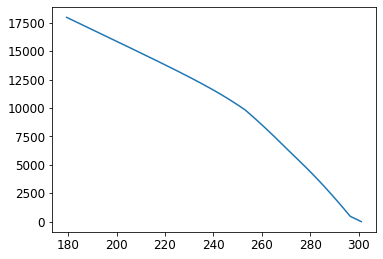

In [67]:

temp_show = temp_ad_data['302']['Tma_'][:,0]
z_show = temp_ad_data['302']['zgrd'][:,0]
plt.plot(temp_show,z_show)

### choose RH profile (from 2020-01-26 ?) with piecewise linear fit

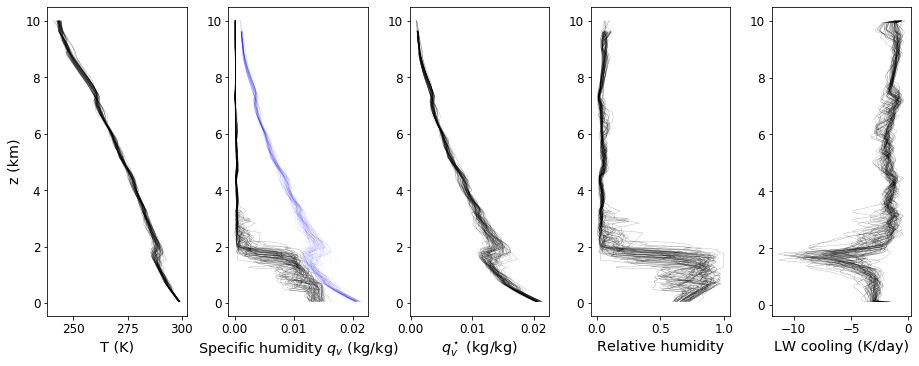

In [32]:
day = '20200126'
z_min = 1000 # m
z_max = 2200 # m

def getProfiles(rad_features, data_day, z_min, z_max):

    #- Mask
    # |qrad| > 5 K/day
    qrad_peak = np.absolute(rad_features.qrad_lw_peak)
    keep_large = qrad_peak > 5 # K/day
    # in box
    lon_day = data_day.longitude[:,50]
    lat_day = data_day.latitude[:,50]
    keep_box = np.logical_and(lon_day < lon_box[1], lat_day >= lat_box[0])
    # high-level peak
    keep_high =  np.logical_and(rad_features.z_net_peak < z_max, # m
                                rad_features.z_net_peak > z_min)
    # combined
    k = np.logical_and(np.logical_and(keep_large,keep_box),keep_high)

    # temperature
    temp = data_day.temperature.values[k,:]
    # specific humidity
    qv = data_day.specific_humidity.values[k,:]
    # relative humidity    
    rh = data_day.relative_humidity.values[k,:]
    # lw cooling
    qradlw = rad_features.qrad_lw_smooth[k,:]

    return temp, qv, rh, qradlw


date = pytz.utc.localize(dt.strptime(day,'%Y%m%d'))
data_day = data_all.sel(launch_time=day)
rad_features = rad_features_all[day]

temp, qv, rh, qradlw = getProfiles(rad_features, data_day, z_min, z_max)
qvstar = qv/rh

fig,axs = plt.subplots(ncols=5,figsize=(16,5.5))

for i_s in range(rh.shape[0]):

    axs[0].plot(temp[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[1].plot(qv[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[1].plot(qvstar[i_s],z,c='b',linewidth=0.3,alpha=0.1)
    axs[2].plot(qvstar[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[3].plot(rh[i_s],z,c='k',linewidth=0.3,alpha=0.4)
    axs[4].plot(qradlw[i_s],z,c='k',linewidth=0.3,alpha=0.4)

axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[4].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

heights_label = ('btw%1.1fand%1.1fkm'%(z_min/1e3,z_max/1e3)).replace('.','p')

plt.savefig(os.path.join(figdir,scriptsubdir,'thermo_profiles_for_high_level_peaks_%s_%s.pdf'%(heights_label,day)),bbox_inches='tight')


/Users/bfildier/anaconda3/envs/pyLMD/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Text(0, 0.5, 'z (km)')

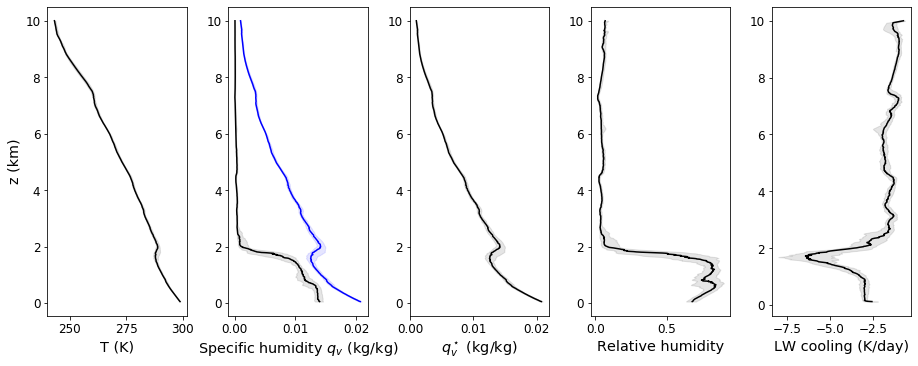

In [33]:
varids = 'temp','qv','qvstar','rh','qradlw'
Nv = len(varids)

# Compute quartile profiles
for varid in varids:

    # get variable
    var = getattr(thismodule,varid)
    # compute quartiles
    var_Q1, var_med, var_Q3 = np.nanpercentile(var,25,axis=0), np.nanpercentile(var,50,axis=0), np.nanpercentile(var,75,axis=0)

    for suffix in 'Q1','med','Q3':
        # reassign in current environment with correct variable name
        setattr(thismodule,'%s_%s'%(varid,suffix),getattr(thismodule,'var_%s'%suffix))
    
    
    
fig,axs = plt.subplots(ncols=5,figsize=(16,5.5))

for i,varid in zip(range(Nv),varids):
    
    # get variable
    for suffix in 'Q1','med','Q3':
        setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'%s_%s'%(varid,suffix)))

    axs[i].plot(var_med,z,c='k')
    axs[i].fill_betweenx(z,var_Q1,var_Q3,color='k',alpha=0.1)

axs[1].plot(qvstar_med,z,c='b')
axs[1].fill_betweenx(z,qvstar_Q1,qvstar_Q3,color='b',alpha=0.1)

axs[0].set_xlabel('T (K)')
axs[1].set_xlabel('Specific humidity $q_v$ (kg/kg)')
axs[2].set_xlabel(r'$q_v^\star$ (kg/kg)')
axs[3].set_xlabel('Relative humidity')
axs[4].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

In [39]:
def piecewise_linear(z:np.array,z_breaks:list,rh_breaks:list):
    """
    Define piecewise linear RH shape with constant value at top and bottom.

    Args:
        z (np.array): z coordinate
        z_breaks (list): z values of break points
        rh_breaks (list): rh values of break points

    Returns:
        np.array: piecewize rh
        
    """
    
    N_breaks = len(z_breaks)
    
    cond_list = [z <= z_breaks[0]]+\
                [np.logical_and(z > z_breaks[i-1],z <= z_breaks[i]) for i in range(1,N_breaks)]+\
                [z > z_breaks[N_breaks-1]]
    def make_piece(k):
        def f(z):
            return rh_breaks[k-1]+(rh_breaks[k]-rh_breaks[k-1])/(z_breaks[k]-z_breaks[k-1])*(z-z_breaks[k-1])
        return f 
    func_list = [lambda z: rh_breaks[0]]+\
                [make_piece(k) for k in range(1,N_breaks)]+\
                [lambda z: rh_breaks[N_breaks-1]]
                
    return np.piecewise(z,cond_list,func_list)

def piecewise_fit(z:np.array,rh:np.array,z_breaks_0:list,rh_breaks_0:list):    
    """
    Compute piecewise-linear fit of RH(z).

    Args:
        z (np.array): z coordinate
        rh (np.array): rh profile
        z_breaks_0 (list): initial z values of break points
        rh_breaks_0 (list): initial rh values of break points

    Returns:
        z_breaks (list): fitted z values of break points
        rh_breaks (list): fitted rh values of break points
        rh_id (np.array): piecewize rh fit

    """

    N_breaks = len(z_breaks_0)
    
    def piecewise_fun(z,*p):
        return piecewise_linear(z,p[0:N_breaks],p[N_breaks:2*N_breaks])

    mask = ~np.isnan(z) & ~np.isnan(rh)
    p , e = optimize.curve_fit(piecewise_fun, z[mask], rh[mask],p0=z_breaks_0+rh_breaks_0)

    rh_id = piecewise_linear(z,p[0:N_breaks],p[N_breaks:2*N_breaks])
    z_breaks= list(p[0:N_breaks])
    rh_breaks = list(p[N_breaks:2*N_breaks])

    return z_breaks,rh_breaks,rh_id

- Fitted parameters:
z_breaks : [1.5341912514304215, 1.9933902218671102]
rh_breaks : [0.7840591213041597, 0.04475777561439605]


Text(0, 0.5, 'z (km)')

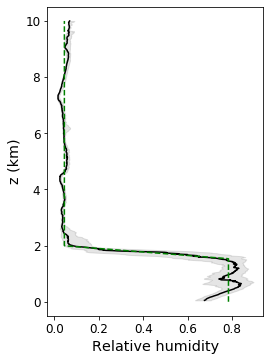

In [42]:
# piecewise linear fit for RH(z)
z_breaks_0 = [1.8,2]
rh_breaks_0 = [0.8,0.1]
z_breaks_id,rh_breaks_id,rh_id = piecewise_fit(z,rh_med,z_breaks_0,rh_breaks_0)

print('- Fitted parameters:')
print('z_breaks :',z_breaks_id)
print('rh_breaks :',rh_breaks_id)

fig,ax = plt.subplots(ncols=1,figsize=(4,5.5))

# get variable
for suffix in 'Q1','med','Q3':
    setattr(thismodule,'var_%s'%suffix,getattr(thismodule,'%s_%s'%(varid,suffix)))

ax.plot(rh_med,z,c='k')
ax.fill_betweenx(z,rh_Q1,rh_Q3,color='k',alpha=0.1)
ax.plot(rh_id,z,'g--')

ax.set_xlabel('Relative humidity')
ax.set_ylabel('z (km)')

# Results

In [123]:
rad_file = os.path.join(radinputdir,'rad_profiles_stepRH20200126_idealized_warming.nc')
rad_file_h2oOnly = os.path.join(radinputdir,'rad_profiles_stepRH20200126_idealized_warming_h2oOnly.nc')
radprf_id = xr.open_dataset(rad_file)
radprf_h2oOnly_id = xr.open_dataset(rad_file_h2oOnly)

check how qv and Qrad change for increasing temperatures, with fixed RH shape


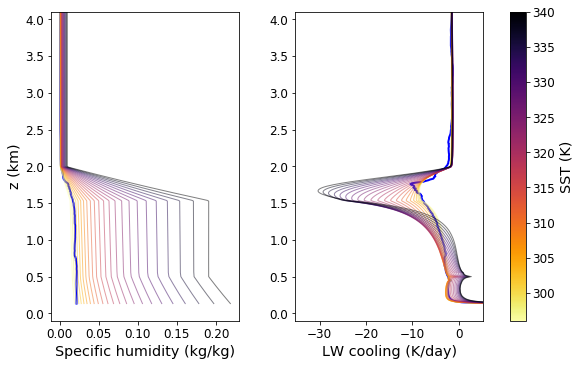

In [121]:
print("check how qv and Qrad change for increasing temperatures, with fixed RH shape")

from itertools import product

SSTs = np.arange(296,342,2)

Nprof = len(SSTs)


radprf = radprf_id
z = radprf.zlay[0] # km

#-- Show

varids = 'h2o','q_rad_lw'
Nv = len(varids)
linestyles = '-','-'
linewidths = 2,1

# cols
var_col = np.array(SSTs,dtype=float)
norm = matplotlib.colors.Normalize(vmin=SSTs[0], vmax=SSTs[-1])
cmap = plt.cm.inferno_r
# cols = cmap(norm(var_col),bytes=True)/255
cols = cmap(norm(var_col),bytes=True)/255

fig,axs = plt.subplots(ncols=Nv,figsize=(5*Nv,5.5))

# fig = plt.figure(figsize=(4*Nv,5.5))

# gs = GridSpec(1, 3, width_ratios=[3,3,1], height_ratios=[1],hspace=0.25,wspace=0.3)
# ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])
# ax3 = fig.add_subplot(gs[2])

# axs = np.array([ax1,ax2])

for i_ax in range(Nv):
    
    ax = axs.flatten()[i_ax]
    varid = varids[i_ax]
    
    ax.plot(radprf[varid].data[0],z,c='b',linewidth=linewidths[0],linestyle=linestyles[0])
    
    for i_prof in range(Nprof):
        
        SST = SSTs[i_prof]
        name = 'RHid_SST%d'%SST
        i_p_file = np.where(radprf_id.name.data == name)[0][0]
        
        var = radprf[varid].data[i_p_file,:]
        col = cols[i_prof]
        
        ax.plot(var,z,c=col,linewidth=linewidths[1],linestyle=linestyles[1],alpha=0.5)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axs.ravel().tolist())
cbar.set_label('SST (K)')

for ax in axs[:2]:
    ax.set_ylim((-0.1,4.1))

# axs[2].set_ylim((-0.1,2.8))
# axs[2].set_xlim((-10.3,0.3))

axs[1].set_xlim((-35.3,5.3))
        
axs[0].set_xlabel('Specific humidity (kg/kg)')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# suptitle at midpoint of left and right x-positions
# mid = (fig.subplotpars.right + fig.subplotpars.left)/2
# plt.suptitle(r'Varying intrusion height at $W=%1.2f$ mm'%W,fontsize=15,x=mid)

plt.savefig(os.path.join(figdir,scriptsubdir,'warming_stepRH20200126_allGHGs.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'warming_stepRH20200126_allGHGs.png'),bbox_inches='tight')

check how qv and Qrad change for increasing temperatures, with fixed RH shape


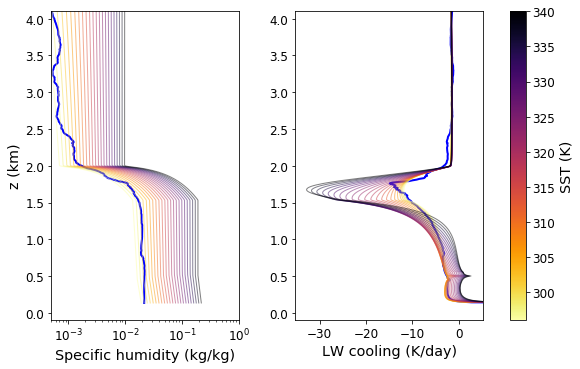

In [128]:
print("check how qv and Qrad change for increasing temperatures, with fixed RH shape")

from itertools import product

SSTs = np.arange(296,342,2)

Nprof = len(SSTs)


radprf = radprf_h2oOnly_id
z = radprf.zlay[0] # km

#-- Show

varids = 'h2o','q_rad_lw'
Nv = len(varids)
linestyles = '-','-'
linewidths = 2,1

# cols
var_col = np.array(SSTs,dtype=float)
norm = matplotlib.colors.Normalize(vmin=SSTs[0], vmax=SSTs[-1])
cmap = plt.cm.inferno_r
# cols = cmap(norm(var_col),bytes=True)/255
cols = cmap(norm(var_col),bytes=True)/255

fig,axs = plt.subplots(ncols=Nv,figsize=(5*Nv,5.5))

# fig = plt.figure(figsize=(4*Nv,5.5))

# gs = GridSpec(1, 3, width_ratios=[3,3,1], height_ratios=[1],hspace=0.25,wspace=0.3)
# ax1 = fig.add_subplot(gs[0])
# ax2 = fig.add_subplot(gs[1])
# ax3 = fig.add_subplot(gs[2])

# axs = np.array([ax1,ax2])

for i_ax in range(Nv):
    
    ax = axs.flatten()[i_ax]
    varid = varids[i_ax]
    
    ax.plot(radprf[varid].data[0],z,c='b',linewidth=linewidths[0],linestyle=linestyles[0])
    
    for i_prof in range(Nprof):
        
        SST = SSTs[i_prof]
        name = 'RHid_SST%d'%SST
        i_p_file = np.where(radprf_id.name.data == name)[0][0]
        
        var = radprf[varid].data[i_p_file,:]
        col = cols[i_prof]
        
        ax.plot(var,z,c=col,linewidth=linewidths[1],linestyle=linestyles[1],alpha=0.5)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=axs.ravel().tolist())
cbar.set_label('SST (K)')

for ax in axs[:2]:
    ax.set_ylim((-0.1,4.1))

# axs[2].set_ylim((-0.1,2.8))
# axs[2].set_xlim((-10.3,0.3))

axs[0].set_xscale('log')
axs[0].set_xlim((5e-4,1))
axs[1].set_xlim((-35.3,5.3))
        
axs[0].set_xlabel('Specific humidity (kg/kg)')
axs[1].set_xlabel('LW cooling (K/day)')
axs[0].set_ylabel('z (km)')

# suptitle at midpoint of left and right x-positions
# mid = (fig.subplotpars.right + fig.subplotpars.left)/2
# plt.suptitle(r'Varying intrusion height at $W=%1.2f$ mm'%W,fontsize=15,x=mid)

plt.savefig(os.path.join(figdir,scriptsubdir,'warming_stepRH20200126_h2oOnly.pdf'),bbox_inches='tight')
plt.savefig(os.path.join(figdir,scriptsubdir,'warming_stepRH20200126_h2oOnly.png'),bbox_inches='tight')